<a href="https://colab.research.google.com/github/mehedihasanbijoy/PyTorch-Speech-Processing/blob/main/Audio%20Classification%201%20(UrbanSound8K)/CNN_UrbanSound8KClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --upgrade

In [2]:
import opendatasets as od

od.download('https://www.kaggle.com/datasets/chrisfilo/urbansound8k')

100%|██████████| 5.61G/5.61G [00:58<00:00, 103MB/s]


In [3]:
import pandas as pd
import torch
import torchaudio
import os
import glob

In [4]:
def extract_audio_file_name(path):
    return path.split("/")[-1]

In [5]:
all_paths = glob.glob("/content/urbansound8k/*/*.wav")

df = pd.DataFrame({"path": all_paths})
df['audio_file_name'] = df['path'].apply(extract_audio_file_name)
df = df.sort_values(by = "audio_file_name")

In [6]:
annotation_df = pd.read_csv("/content/urbansound8k/UrbanSound8K.csv")
annotation_df = annotation_df.sort_values(by = "slice_file_name")

annotation_df['path'] = df['path'].values

annotation_df = annotation_df[["path", "slice_file_name", "fsID", "start", "end", "salience", "fold", "classID", "class"]]
annotation_df = annotation_df.reset_index(drop=True)
annotation_df

,path,slice_file_name,fsID,start,end,salience,fold,classID,class
0,/content/urbansound8k/fold5/100032-3-0-0.wav,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,/content/urbansound8k/fold5/100263-2-0-117.wav,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,/content/urbansound8k/fold5/100263-2-0-121.wav,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,/content/urbansound8k/fold5/100263-2-0-126.wav,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,/content/urbansound8k/fold5/100263-2-0-137.wav,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...,...
8727,/content/urbansound8k/fold7/99812-1-2-0.wav,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,/content/urbansound8k/fold7/99812-1-3-0.wav,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,/content/urbansound8k/fold7/99812-1-4-0.wav,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,/content/urbansound8k/fold7/99812-1-5-0.wav,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [7]:
class UrbanSound8K(torch.utils.data.Dataset):
    def __init__(self, df, target_sample_rate, num_samples, transformation=None):
        self.df = df
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        self.transformation = transformation

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df['path'][idx]
        audio_label = self.df['classID'][idx]
        audio_signal, sr = torchaudio.load(audio_path)

        audio_signal = self._resample_if_necessary(audio_signal, sr)
        audio_signal = self._mix_down_if_necessary(audio_signal)
        audio_signal = self._cut_down_if_necessary(audio_signal)
        audio_signal = self._right_pad_if_necessary(audio_signal)

        if self.transformation:
            audio_signal = self.transformation(audio_signal)

        return audio_signal, torch.tensor(audio_label)


    def _right_pad_if_necessary(self, audio_signal):
        audio_signal_length = audio_signal.shape[1]
        if audio_signal_length < self.num_samples:
            num_missing_samples = self.num_samples - audio_signal_length
            last_dim_padding = (0, num_missing_samples)
            audio_signal = torch.nn.functional.pad(audio_signal, last_dim_padding)
        return audio_signal


    def _cut_down_if_necessary(self, audio_signal):
        if audio_signal.shape[1] > self.num_samples:
            audio_signal = audio_signal[:, :self.num_samples]
        return audio_signal


    def _mix_down_if_necessary(self, audio_signal):
        if audio_signal.shape[0] > 1:
            audio_signal = torch.mean(audio_signal, dim=0, keepdim=True)
        return audio_signal


    def _resample_if_necessary(self, audio_signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.target_sample_rate)
            audio_signal = resampler(audio_signal)
        return audio_signal

In [8]:
SAMPLE_RATE = 22050
NUM_SAMPLES = 22050
MEL_SPECTROGRAM = torchaudio.transforms.MelSpectrogram(
    sample_rate = SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64
)

In [9]:
dataset = UrbanSound8K(
    df = annotation_df,
    target_sample_rate = SAMPLE_RATE,
    num_samples = NUM_SAMPLES,
    transformation = MEL_SPECTROGRAM,
)

In [10]:
audio, label = dataset.__getitem__(10)
label, audio.shape, audio

(tensor(1),
 torch.Size([1, 64, 44]),
 tensor([[[9.1039e-06, 3.6455e-03, 1.7155e-02,  ..., 9.5240e-03,
           4.6061e-03, 3.2610e-02],
          [3.1634e-06, 1.0775e-01, 8.0601e-02,  ..., 3.4591e-02,
           1.5594e-02, 5.8635e-02],
          [6.6457e-07, 4.4061e-01, 1.0418e-01,  ..., 9.5598e-01,
           2.1417e-01, 2.8359e-01],
          ...,
          [9.7898e-08, 1.1593e-02, 3.3238e-02,  ..., 3.3709e-02,
           1.8227e-01, 1.4622e-01],
          [5.7078e-08, 2.0460e-02, 6.9060e-02,  ..., 2.1985e-02,
           7.2155e-02, 9.6141e-02],
          [7.9825e-08, 1.9400e-02, 2.1965e-02,  ..., 1.9975e-02,
           5.1734e-02, 2.9411e-02]]]))

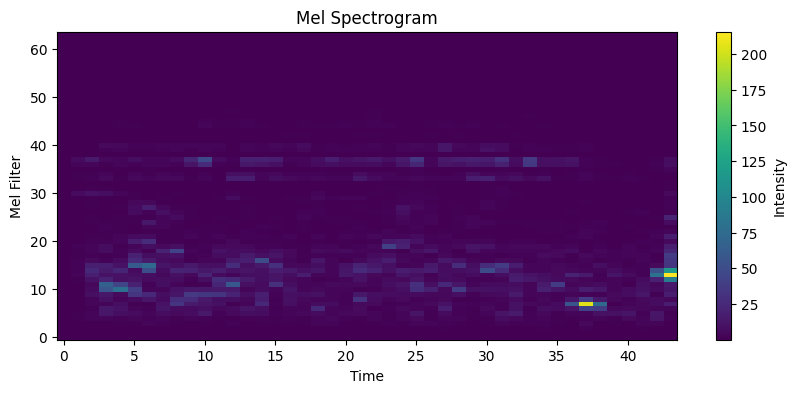

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.imshow(audio.numpy()[0], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Intensity')
plt.xlabel('Time')
plt.ylabel('Mel Filter')
plt.title('Mel Spectrogram')
plt.show()

In [12]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, stride = 1, padding = 2)
        self.conv2 = torch.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 2)
        self.conv3 = torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 2)
        self.conv4 = torch.nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 2)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear = torch.nn.Linear(in_features = 128*5*4, out_features = 10)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.maxpool(self.relu(self.conv1(x)))
        x = self.maxpool(self.relu(self.conv2(x)))
        x = self.maxpool(self.relu(self.conv3(x)))
        x = self.maxpool(self.relu(self.conv4(x)))
        x = x.flatten()
        x = self.linear(x)
        return x

In [13]:
model = CNN()
model(dataset.__getitem__(0)[0])

tensor([ -8.5887,   6.7802,  -8.6524,  -7.7928,  -8.1326,  -2.0110, -10.0918,
         -4.3475,  -3.3174,   3.3649], grad_fn=<ViewBackward0>)